<a href="https://colab.research.google.com/github/big-muzzy/Autoencoders/blob/master/Convolutional_Autoencoder_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Этим блоком будем визуализировать
import numpy as np
import matplotlib.pyplot as plt

# Библиотеки Pytorch
import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет
from torch.autograd import Variable # для автоматического дифференциатора


Вспомогательная функция для рисования

In [2]:
def plotImages(startIndex, pred): # создадим функцию для вывода изображений как картинок
  n = 10  # количество картинок, которые хотим показать
  plt.figure(figsize=(17, 3)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = i + startIndex # startIndex - начиная с какого индекса хотим заплотить картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(28, 28)) # отрисуем обработанные сеткой картинки в размере 28*28
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [3]:
# Обучающая выборка
trainDataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
# Тестовая выборка
testDataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

batchSize = 100

# Dataset Loader (подготовка данных для сети)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, # Какой датасет
                                           batch_size=batchSize, # На сколько batch разделен
                                           shuffle=True) 

testLoader = torch.utils.data.DataLoader(dataset=testDataset, #  Какой датасет
                                          batch_size=batchSize, # На сколько batch разделен
                                          shuffle=False)


Посмотрим на загруженные данные.

torch.Size([10000, 28, 28])


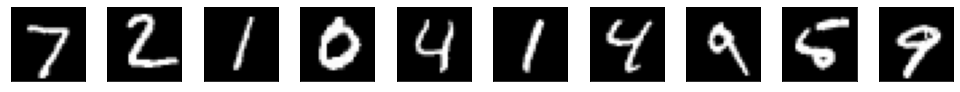

In [4]:
print(testDataset.data.shape)
plotImages(0, testDataset.data.numpy())

Создадим модель

In [5]:
# Создаем класс
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, (3, 3), padding=1), #(128, 28, 28)
            nn.ReLU(True),
            nn.Conv2d(128, 64, (3, 3), padding=1), #(64, 28, 28)
            nn.ReLU(True),
            nn.MaxPool2d((2, 2)), #(64, 14, 14)
            nn.Conv2d(64, 128, (3, 3), padding=1), #(128, 14, 14)
            nn.ReLU(True),
            nn.Conv2d(128, 64, (3, 3), padding=1), #(64, 14, 14)
            nn.ReLU(True),
            nn.MaxPool2d((2, 2)) #(64, 7, 7)        
        )
        self.dense = nn.Sequential(
            nn.Linear(7*7*64, 128),
            nn.ReLU(True),
            nn.Linear(128, 7*7*64),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, (2, 2), stride=2), #(128, 14, 14)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, (2, 2), stride=2), #(64, 28, 28)
            nn.ReLU(True),
            nn.Conv2d(64, 1, (3, 3), padding=1), #(1, 28, 28)
            nn.ReLU(True)
        )

    def forward(self, x): 
        layer = self.encoder(x)
        layer = layer.view(layer.size()[0], np.prod(layer.size()[1:])) 
        layer = self.dense(layer)
        layer = layer.view(layer.size()[0], 64, 7, 7)
        layer = self.decoder(layer)
        return layer

model = Autoencoder().cuda()

Оптимизатор, функция ошибки (MSE)

In [6]:
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # оптимизатор
losses = [] # сюда будет добавляться средняя ошибка. Список будем использовать для построения графика
model.train() # переход в режим обучения

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=3136, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d

Обучаем модель


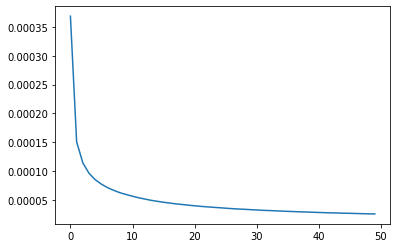

In [7]:
numEpochs = 50
for epoch in range(numEpochs): # количество эпох
    lossTot = 0 # потери в совокупности
    for i, (images, labels) in enumerate(trainLoader): # проходимся по всем данным в batch
        images = images.cuda()
        optimizer.zero_grad() # обнуляем градиент
        outputs = model(images) # здесь наше предсказание
        loss = criterion(outputs, images) # считаем ошибку 
        loss.backward()  # обратное распространение. 
                         # x.grad += dloss/dx для всех параметров x
        lossTot +=loss.detach().data # инкремент ошибки
        optimizer.step() # следующий шаг спуска
    
    losses.append(lossTot/len(trainDataset)) # вычисляем среднюю ошибку и добавляем в список

plt.plot(losses) # График нашего обучения
plt.show()

In [8]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=3136, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d

Посмотрим на результат

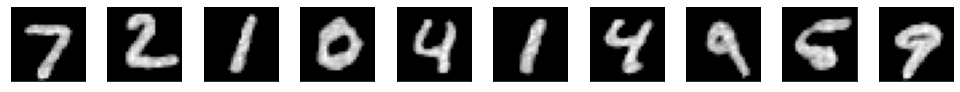

In [9]:
pred = model(testDataset.data[:100].float().view(100,1,28,28).cuda())
plotImages(0, pred.detach().cpu().numpy().reshape(100, 28, 28)*2)